In [1]:
import sys
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
from metrics.query import DataFrameQuery
from common.utils import *
from metrics.utils import *

#from sklearn.feature_selection import mutual_info_regression MISSIN?
from dadapy.data import Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score, \
                                    adjusted_mutual_info_score
from sklearn.metrics import f1_score

from pathlib import Path
from functools import partial
from collections import Counter
import tqdm
import seaborn as sns

#!export OMP_NUM_THREADS=1

# OLD

In [2]:
f1_score_micro = partial(f1_score, average="micro")
_COMPARISON_METRICS = {"adjusted_rand_score":adjusted_rand_score, 
                       "adjusted_mutual_info_score":adjusted_mutual_info_score, 
                       "mutual_info_score":mutual_info_score,
                       "f1_score": f1_score_micro}

In [97]:
out_layer = []
for num_layer in [3,4,5,6,7]:
    out = []
    for train_instances in tqdm.tqdm_notebook([0,1,2,3,4,5], desc = "Computing shot"):
        dict_query = {"method":"last",
                      "model_name":  "meta-llama/Llama-3-8b-hf",
                      "train_instances": train_instances}                               
        tsm = TensorStorageManager()
        query = DataFrameQuery(dict_query)
        hidden_states,logits, hidden_states_stat = tsm.retrieve_tensor(query, "npy")
        
        subjects = hidden_states_stat["dataset"].values
        
        layer_data = hidden_states[:,num_layer,:]
        #layer_data = layer_data[mask] 
        base_unique, base_idx, base_inverse = np.unique(layer_data, axis=0, return_index=True, return_inverse=True)
        indices = np.sort(base_idx)
        base_repr = layer_data[indices]
        
        subjects = hidden_states_stat["dataset"].values
        subjects = subjects[indices]
        subject_to_number = {subject: i for i, subject in enumerate(subjects)}
        subjects = [subject_to_number[subject] for subject in subjects]
        
        #do clustering
        data = Data(coordinates = base_repr)
        ids, _, _ = data.return_id_scaling_gride(range_max=100)
        data.set_id(ids[3])
        data.compute_density_kNN(k=16)
        assignment = data.compute_clustering_ADP(Z=1.6, halo=True)
        
        cluster_indices = data.cluster_indices
        cluster_centers = data.cluster_centers
        
        num_clusters = len(cluster_indices)
        vars = []
        centroid = np.mean(data.X)
        var_dataset = np.mean((np.sum(((data.X - centroid)**2), axis = 1)**0.5) )
        for i in range(num_clusters):
            coord = data.X[cluster_indices[i]]
            var = np.mean((np.sum(((coord - data.X[cluster_centers[i]])**2), axis=1)**0.5))*len(cluster_indices[i])
            vars.append(var)
        denom = np.sum([len(cluster_indices[i]) for i in range(num_clusters)])
        out.append((np.sum(vars)/denom) / var_dataset)
        with open(f'var_{num_layer}.pkl', 'wb') as file:
            pickle.dump(out, file)
    out_layer.append(out)


/tmp/ipykernel_43155/1454540589.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for train_instances in tqdm.tqdm_notebook([0,1,2,3,4,5], desc = "Computing shot"):


Computing shot:   0%|          | 0/6 [00:00<?, ?it/s]

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 128 or lower

KeyboardInterrupt



In [ ]:
var = ((np.sum(((coord - data.X[cluster_centers[i]])**2))**0.5) )
            

In [81]:
np.mean((np.sum(((coord - data.X[cluster_centers[i]])**2), axis=1)**0.5))

3.3843065085503854

In [ ]:
sns.set_style("whitegrid")
palette = sns.color_palette("tab10", 10)
for layer in [4, 5, 6, 7]:
    with open(f'var_{layer}.pkl', 'rb') as file:
        var = pickle.load(file)
    sns.lineplot(x=range(6), y=var, label = f"layer: {layer}", linewidth = conf_size.linewidth)
    sns.scatterplot(x=range(6), y=var, s = conf_size.s)
plt.xlabel("shot", fontsize=conf_size.xlabel)
plt.ylabel("var", fontsize=conf_size.ylabel)
plt.legend(fontsize=conf_size.legend)
plt.title("Variance ratio", fontsize=conf_size.title)
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
plt.tick_params(axis='y', labelsize=conf_size.yticks)
plt.tight_layout()
plt.savefig("var_8b.png")

In [42]:
var[0]*0.35

79230.14188021951

In [4]:
subjects = hidden_states_stat["dataset"].values

In [5]:
num_layer = 7
layer_data = hidden_states[:,num_layer,:]
#layer_data = layer_data[mask] 
base_unique, base_idx, base_inverse = np.unique(layer_data, axis=0, return_index=True, return_inverse=True)
indices = np.sort(base_idx)
base_repr = layer_data[indices]

subjects = hidden_states_stat["dataset"].values
subjects = subjects[indices]
subject_to_number = {subject: i for i, subject in enumerate(subjects)}
subjects = [subject_to_number[subject] for subject in subjects]

#do clustering
data = Data(coordinates = base_repr)
ids, _, _ = data.return_id_scaling_gride(range_max=100)
data.set_id(ids[3])
data.compute_density_kNN(k=16)
assignment = data.compute_clustering_ADP(Z=1.6, halo=True)

In [7]:
cluster_indices = data.cluster_indices
cluster_centers = data.cluster_centers


In [14]:
num_clusters = len(cluster_indices)
vars = []
centroid = np.mean(data.X)
var_dataset = np.sum(data.X - centroid)**2 / data.X.shape[0] 
for i in range(num_clusters):
    coord = data.X[cluster_indices[i]]
    var = ((np.sum(coord - data.X[cluster_centers[i]])**2) / len(cluster_indices[i])) / var_dataset
    vars.append(var)
    

In [17]:
len(vars)

57

In [ ]:
mask = np.load("/orfeo/scratch/dssc/zenocosini/mmlu_result/test_mask_100.npy")
results = []
objects = []
#num_layers
for shot in [0,2,5]:
    dict_query = {"method":"last",
              "model_name":  "meta-llama/Llama-3-8b-hf",
              "train_instances": shot}                               
    tsm = TensorStorageManager()
    query = DataFrameQuery(dict_query)
    hidden_states,logits, hidden_states_stat = tsm.retrieve_tensor(query, "npy")
    for num_layer in tqdm.notebook.tqdm(range(1,num_layers), desc = "Processing layer"):
        layer_data = hidden_states[:,num_layer,:]
        #layer_data = layer_data[mask] 
        base_unique, base_idx, base_inverse = np.unique(layer_data, axis=0, return_index=True, return_inverse=True)
        indices = np.sort(base_idx)
        base_repr = layer_data[indices]
        
        subjects = hidden_states_stat["dataset"].values
        subjects = subjects[indices]
        subject_to_number = {subject: i for i, subject in enumerate(subjects)}
        subjects = [subject_to_number[subject] for subject in subjects]
        
        #do clustering
        data = Data(coordinates = base_repr)
        ids, _, _ = data.return_id_scaling_gride(range_max=100)
        data.set_id(ids[3])
        data.compute_density_kNN(k=16)
        assignment = data.compute_clustering_ADP(Z=1.6, halo=True)
        row = [assignment]
        for key, func in _COMPARISON_METRICS.items():
            row.append(func(assignment, subjects))
        row.append(shot)
        results.append(row)
        objects.append(data)

In [50]:
df = pd.DataFrame(results, columns=["assignments", "adjusted_rand_score",  "adjusted_mutual_info_score", "mutual_info_score", "f1_score", "shot"])

# Plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
import pandas as pd

import sys
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
from metrics.query import DataFrameQuery
from common.utils import *
from metrics.utils import *

#from sklearn.feature_selection import mutual_info_regression MISSIN?
from dadapy.data import Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score, \
                                    adjusted_mutual_info_score
from sklearn.metrics import f1_score

from pathlib import Path
from functools import partial
from collections import Counter
import tqdm
import seaborn as sns
from common.conifg_plot import ConfigPlotSize

In [2]:
conf_size = ConfigPlotSize()

In [71]:
df_0 = pd.read_pickle("/orfeo/scratch/dssc/zenocosini/mmlu_result/transposed_dataset/metrics_417464/label_clustering_dataset.pkl")

In [72]:
df_1 = pd.read_pickle("/orfeo/scratch/dssc/zenocosini/mmlu_result/transposed_dataset/metrics_416953/label_clustering_dataset.pkl")

In [73]:
df = pd.concat([df_0,df_1])

In [74]:
df.to_pickle("/orfeo/scratch/dssc/zenocosini/mmlu_result/transposed_dataset/result/label_clustering_dataset.pkl")

In [3]:
df = pd.read_pickle("/orfeo/scratch/dssc/zenocosini/mmlu_result/transposed_dataset/result/label_clustering_dataset.pkl")

In [4]:
def determine_shot(model):
    """ Determine the shot number based on model name. """
    return 4 if "70" in model else 5
def mutual_info(assignments, subjects):
    # Filter out unassigned points
    valid_indices = assignments != -1
    return mutual_info_score(assignments[valid_indices], subjects[valid_indices])

In [5]:
def compute_metrics(df):
    df_rows = []
    for row in df.iterrows():
        row = row[1]
        cluster_assignment_all = row["clusters_assignment"]
        n_layers = len(cluster_assignment_all)
        num_clusters = np.zeros(n_layers)
        num_assigned_points = np.zeros(n_layers)
        mean_cluster_size = np.zeros(n_layers)
        var_cluster_size = np.zeros(n_layers)
        entropy_values = np.zeros(n_layers)
        fraction_most_represented = np.zeros(n_layers)
        subjects_all = np.array(row["labels"])
        for i in range(n_layers):
            assignments = cluster_assignment_all[i]
            subjects = subjects_all[i]

            # Calculate cluster metrics
            valid_assignments = assignments[assignments != -1]
            unique_clusters, counts = np.unique(valid_assignments, return_counts=True)

            num_clusters[i] += len(unique_clusters)
            num_assigned_points[i] += len(valid_assignments)
            mean_cluster_size[i] += np.mean(counts)
            var_cluster_size[i] += np.var(counts)
            # Entropy of the distribution of assignments
            # Fraction of the most represented class
            for cluster,count_cluster in zip(unique_clusters, counts):
                iter_subject = subjects[assignments == cluster]
                unique_sub, counts_sub = np.unique(iter_subject, return_counts=True)
                entropy_values[i] += entropy(counts_sub)*count_cluster
                if len(counts) > 0:
                    fraction_most_represented[i] += (np.max(counts_sub) / np.sum(counts_sub))*count_cluster
                else:
                    fraction_most_represented[i] += 0
                
            entropy_values[i] = entropy_values[i] / unique_clusters.shape[0]
            fraction_most_represented[i] =  fraction_most_represented[i] / unique_clusters.shape[0]
            
        df_rows.append([row["model"],
                    row["train_instances"],
                    num_clusters, 
                    num_assigned_points, 
                    mean_cluster_size, 
                    var_cluster_size, 
                    entropy_values, 
                    fraction_most_represented])

    df_out = pd.DataFrame(df_rows, columns=["model", 
                                        "shot", 
                                        "num_clusters", 
                                        "num_assigned_points", 
                                        "mean_cluster_size", 
                                        "var_cluster_size", 
                                        "entropy_values", 
                                        "fraction_most_represented"])
    return df_out



In [ ]:
def tick_computer(n_layers, lenght):
    if n_layers < 50:
        tick_positions = np.arange(1, lenght, 4)  # Generates positions 0, 4, 8, ...
    else:
        tick_positions = np.arange(1, lenght, 8)  # Generates positions 0, 4, 8, ...
    
    tick_labels = tick_positions  # Get the corresponding labels from x
    return tick_labels, tick_positions

In [53]:
def average_custom_blocks(x, y, n):
    # Initialize lists to store averages
    x_avg = []
    y_avg = []

    # Handle the first block [0:n]
    
    y_avg.append(np.mean(y[0:n]))
    
    # Handle the second block [0:n+1]
    if len(x) > n:
        
        y_avg.append(np.mean(y[0:n+1]))

    # Handle subsequent blocks [i:n+i] starting from i=1
    for i in range(1, len(x) - n):
        
        y_avg.append(np.mean(y[i:n+i+1]))

    return np.arange(len(y_avg)), np.array(y_avg)

In [55]:
def plot_box(metrics, model):
    plt.figure(figsize=(conf_size.width, conf_size.height))
    sns.set_style("whitegrid")
    metrics_0 = metrics.query(f"model=='{model}'" \
                              f"and shot==0")
    metrics_2 = metrics.query(f"model=='{model}'" \
                              f"and shot==2")
    metrics_5 = metrics.query(f"model=='{model}'" \
                              f"and shot=={determine_shot(model)}")


    n_layers = metrics_0["num_clusters"].values[0].shape[0]
    if "70" in model:
        n = 5
    else:
        n = 3
    
    if n_layers < 50:
        tick_positions = np.arange(1, n_layers, 4)  # Generates positions 0, 4, 8, ...
    else:
        tick_positions = np.arange(1, n_layers, 8)  # Generates positions 0, 4, 8, ...
    
    tick_labels = tick_positions  # Get the corresponding labels from x
    print(n_layers)
    for n,ctx in enumerate(zip([metrics_0,metrics_2,metrics_5],
                            ["0shot", "2shot", "5shot"]
                           )):
        plt.figure(figsize=(conf_size.width, conf_size.height))
        sns.set_style("whitegrid")
        metrics_iter,label = ctx
        # CLUSTER SIZE DISTRIBUTION
        colors = plt.cm.viridis(np.linspace(0, 1, n_layers))
        csd_data = []
        for i in range(n_layers):
            for _ in range(int(np.random.rand() * 10 + 10)):  # Random replication for illustrative purposes
                csd_data.append({
                    "Layer": f"Layer {i+1}",
                    "Cluster Size": np.random.normal(metrics_iter["mean_cluster_size"].values[0][i], np.sqrt(metrics_iter["var_cluster_size"].values[0][i]))
                })

        df = pd.DataFrame(csd_data)
        y=metrics_iter["fraction_most_represented"].values[0]
        layers = np.arange(n_layers)
        print(df["Cluster Size"].values)
        x_avg, y_avg = average_custom_blocks(layers, df["Cluster Size"].values, n)
        df = pd.DataFrame({"Range of Layer": x_avg, "Cluster Size": y_avg})
        sns.boxplot(x='Range of Layer', y='Cluster Size', data=df, hue='Range of Layer', legend=False,palette="viridis")
        avg_metrics_iter_mean, avg_metrics_iter_var = average_custom_blocks(metrics_iter["mean_cluster_size"].values[0], metrics_iter["var_cluster_size"].values[0], n)
        avg_metrics_iter_var = np.sqrt(avg_metrics_iter_var)
        colors = plt.cm.viridis(np.linspace(0, 1, avg_metrics_iter_mean.shape[0]))
        for i,(mean,var) in enumerate(zip(avg_metrics_iter_mean, avg_metrics_iter_var)):
            plt.errorbar(i, mean, yerr=var, fmt='o-', color=colors[i])
        plt.title(f"Cluster Size Distribution {label}", fontsize=conf_size.title)
        plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
        plt.ylabel("Mean +/- SD", fontsize=conf_size.ylabel)
        plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
        plt.tick_params(axis='y', labelsize=conf_size.yticks)
        plt.legend(fontsize=conf_size.legend)
        plt.savefig(f"plots_clustering/{model[11:][:-3]}-{label}-box.png")
        plt.tight_layout()
        plt.show()



In [57]:
def plot_metrics(metrics,model):

    sns.set_style("whitegrid")
    
    
    metrics_0 = metrics.query(f"model=='{model}'" \
                              f"and shot==0")
    metrics_2 = metrics.query(f"model=='{model}'" \
                              f"and shot==2")
    metrics_5 = metrics.query(f"model=='{model}'" \
                              f"and shot=={determine_shot(model)}")
    if "70" in model:
        n = 5
    else:
        n = 3
    
    n_layers = int(metrics_0["num_clusters"].values[0].shape[0])
    print(n_layers)
    

    plt.figure(figsize=(conf_size.width, conf_size.height))
    figures = []    

    for metrics_iter,label, marker in zip([metrics_0,metrics_2,metrics_5],
                            ["0shot", "2shot", "5shot"],
                            ["o","o","X"]
                           ):
        # # NUM CLUSTERS
        sns.set_style("whitegrid")
        layers = np.arange(n_layers)
        y = metrics_iter["num_clusters"].values[0]    
        x_avg, y_avg = average_custom_blocks(layers, y, n)
        sns.lineplot(x=x_avg, y=y_avg, label = label, linewidth = conf_size.linewidth)
        sns.scatterplot(x=x_avg, y=y_avg,marker=marker, s = conf_size.s)
    plt.title("Number of Clusters", fontsize=conf_size.title)
    plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
    plt.ylabel("Number of Clusters", fontsize=conf_size.ylabel)
    tick_labels, tick_positions = tick_computer(n_layers, y_avg.shape[0])
    plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
    plt.tick_params(axis='y', labelsize=conf_size.ylabel)
    plt.legend(fontsize=conf_size.legend)
    plt.tight_layout()
    plt.savefig(f"dendogram/100/{model[11:][:-3]}-num-cluster.png")

    plt.show()
        
        
    plt.figure(figsize=(conf_size.width, conf_size.height))
    figures = []    
    for metrics_iter,label, marker in zip([metrics_0,metrics_2,metrics_5],
                            ["0shot", "2shot", "5shot"],
                            ["o","o","X"]
                           ):
        #NUM ASSIGNED POINTS
        # Reshape x and y to have 'n' elements per row, ignoring the remainder
        y=metrics_iter["num_assigned_points"].values[0]
        x_avg, y_avg = average_custom_blocks(layers, y, n)
        sns.set_style("whitegrid")
        sns.lineplot(x=x_avg, y=y_avg, label = label, linewidth = conf_size.linewidth)
        sns.scatterplot(x=x_avg, y=y_avg, marker=marker,s = conf_size.s)
    plt.title("Number of Assinged Points", fontsize=conf_size.title)
    plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
    plt.ylabel("Number of Assinged Points", fontsize=conf_size.ylabel)
    tick_labels, tick_positions = tick_computer(n_layers, y_avg.shape[0])
    plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
    plt.tick_params(axis='y', labelsize=conf_size.ylabel)
    plt.legend(fontsize=conf_size.legend)
    plt.tight_layout()
    plt.savefig(f"dendogram/100/{model[11:][:-3]}-num-ass-point.png")

    plt.show()
        
    plt.figure(figsize=(conf_size.width, conf_size.height))
    figures = []    
    for metrics_iter,label, marker in zip([metrics_0,metrics_2,metrics_5],
                            ["0shot", "2shot", "5shot"],
                            ["o","o","X"]
                           ):
        sns.set_style("whitegrid")
        
        y=metrics_iter["entropy_values"].values[0]
        x_avg, y_avg = average_custom_blocks(layers, y, n)
        sns.lineplot(x = x_avg, y = y_avg, label = label, linewidth = conf_size.linewidth)
        sns.scatterplot(x = x_avg, y = y_avg, marker=marker,s = conf_size.s)
    plt.title("Entropy of Cluster Distribution", fontsize=conf_size.title)
    plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
    plt.ylabel("Entropy", fontsize=conf_size.ylabel)
    tick_labels, tick_positions = tick_computer(n_layers, y_avg.shape[0])
    plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
    plt.tick_params(axis='y', labelsize=conf_size.yticks)
    plt.legend(fontsize=conf_size.legend)
    plt.tight_layout()
    plt.savefig(f"dendogram/100/{model[11:][:-3]}-entropy.png")
    plt.show()
    
    plt.figure(figsize=(conf_size.width, conf_size.height))
    figures = []    
    for metrics_iter, label, marker in zip([metrics_0,metrics_2,metrics_5],
                            ["0shot", "2shot", "5shot"],
                            ["o","o","X"]
                           ):    
        sns.set_style("whitegrid")
        y=metrics_iter["fraction_most_represented"].values[0]
        x_avg, y_avg = average_custom_blocks(layers, y, n)
        sns.lineplot(x = x_avg, y = y_avg, label = label, linewidth = conf_size.linewidth)
        sns.scatterplot(x = x_avg, y = y_avg, marker=marker, s = conf_size.s)
    plt.title("Fraction of Most Represented Class", fontsize=conf_size.title)
    plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
    plt.ylabel("Fraction", fontsize=conf_size.ylabel)
    tick_labels, tick_positions = tick_computer(n_layers, y_avg.shape[0])
    plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
    plt.yticks(ticks = 
    plt.tick_params(axis='y', labelsize=conf_size.yticks)
    plt.legend(fontsize=21)
    plt.tight_layout()
    plt.savefig(f"dendogram/100/{model[11:][:-3]}-frac_most_repr.png")
    plt.show()
    



    

In [59]:
!pwd

/orfeo/cephfs/home/dssc/zenocosini/helm_suite/MCQA_Benchmark/notebooks/clustering


40


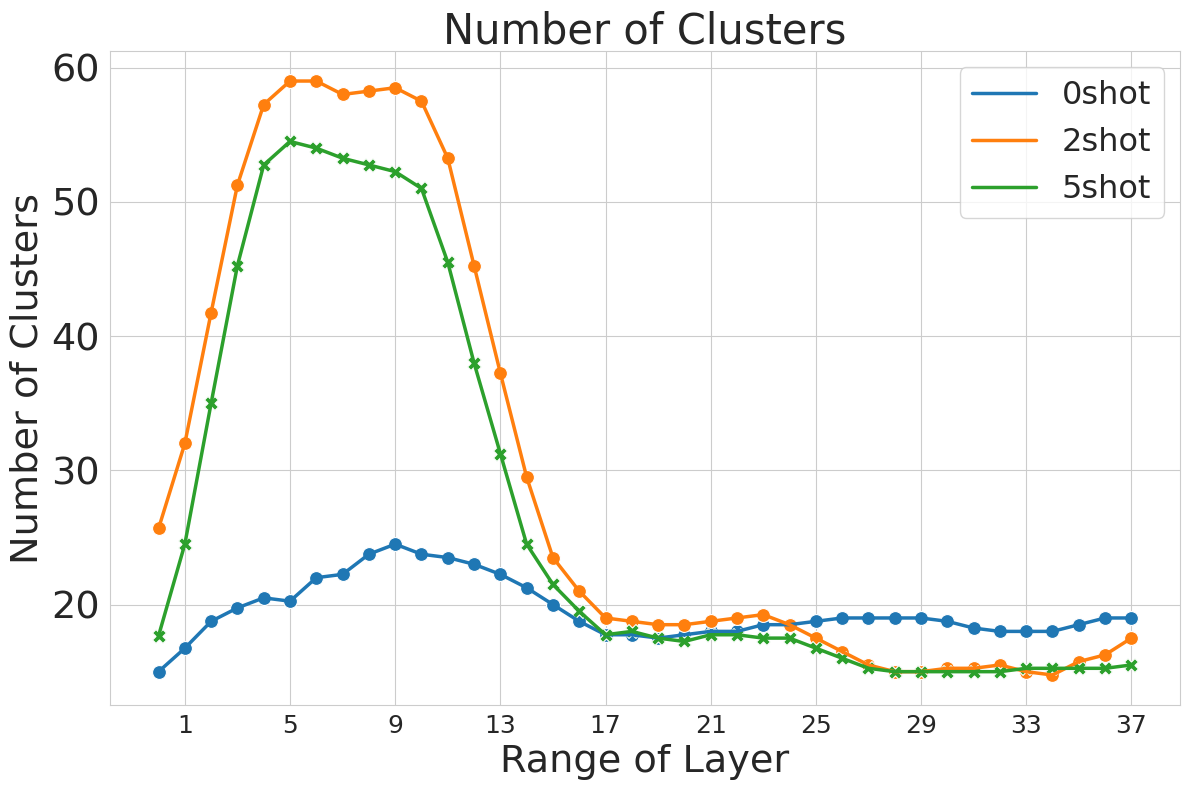

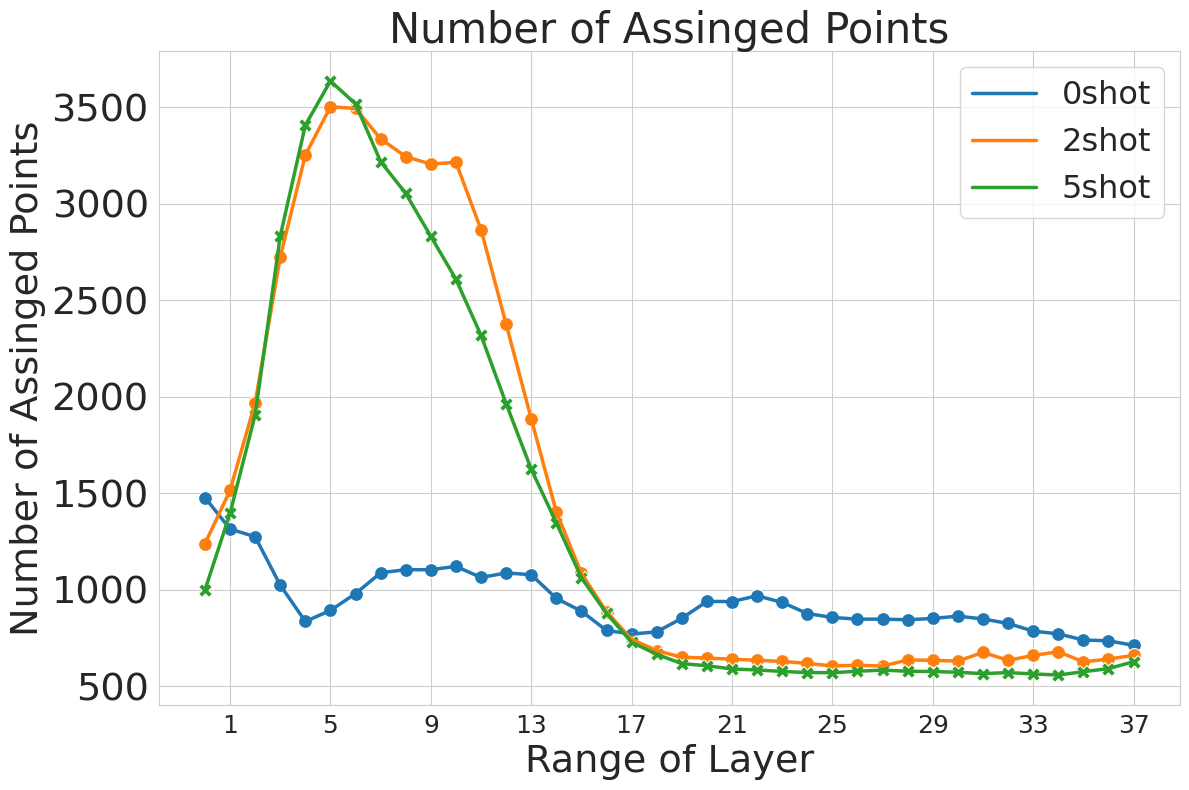

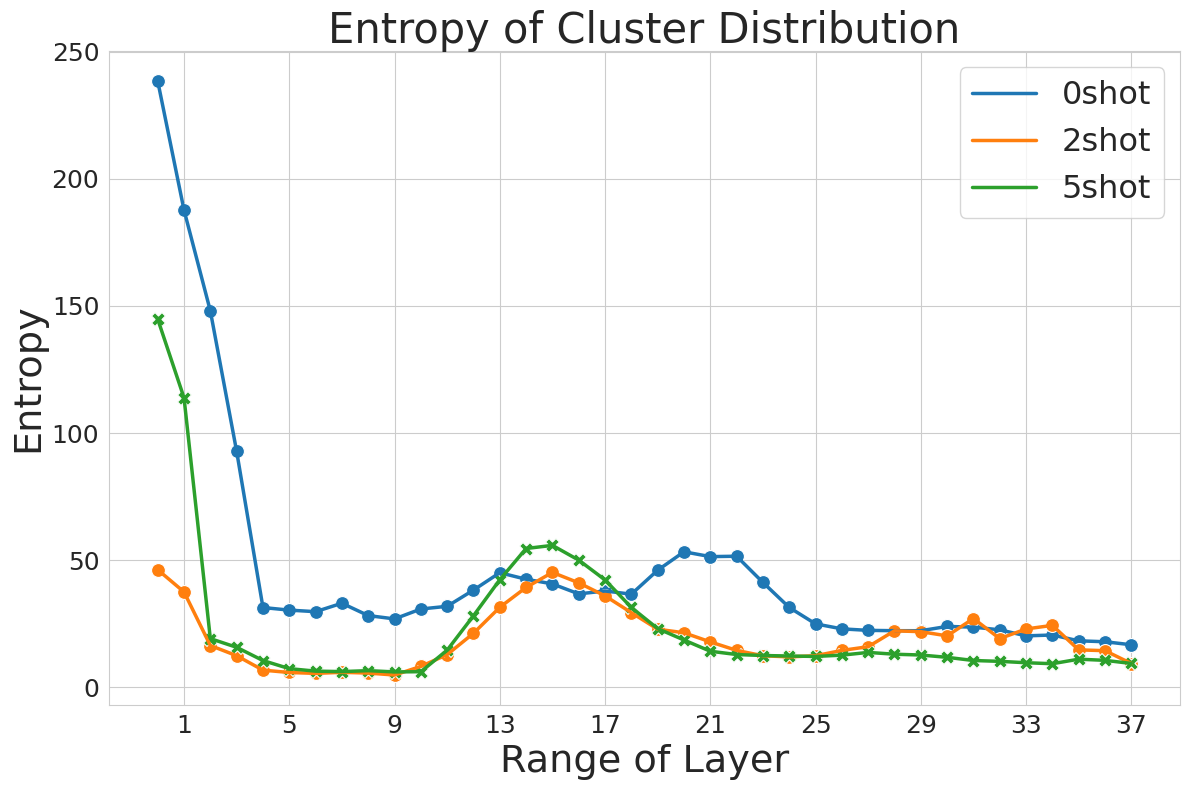

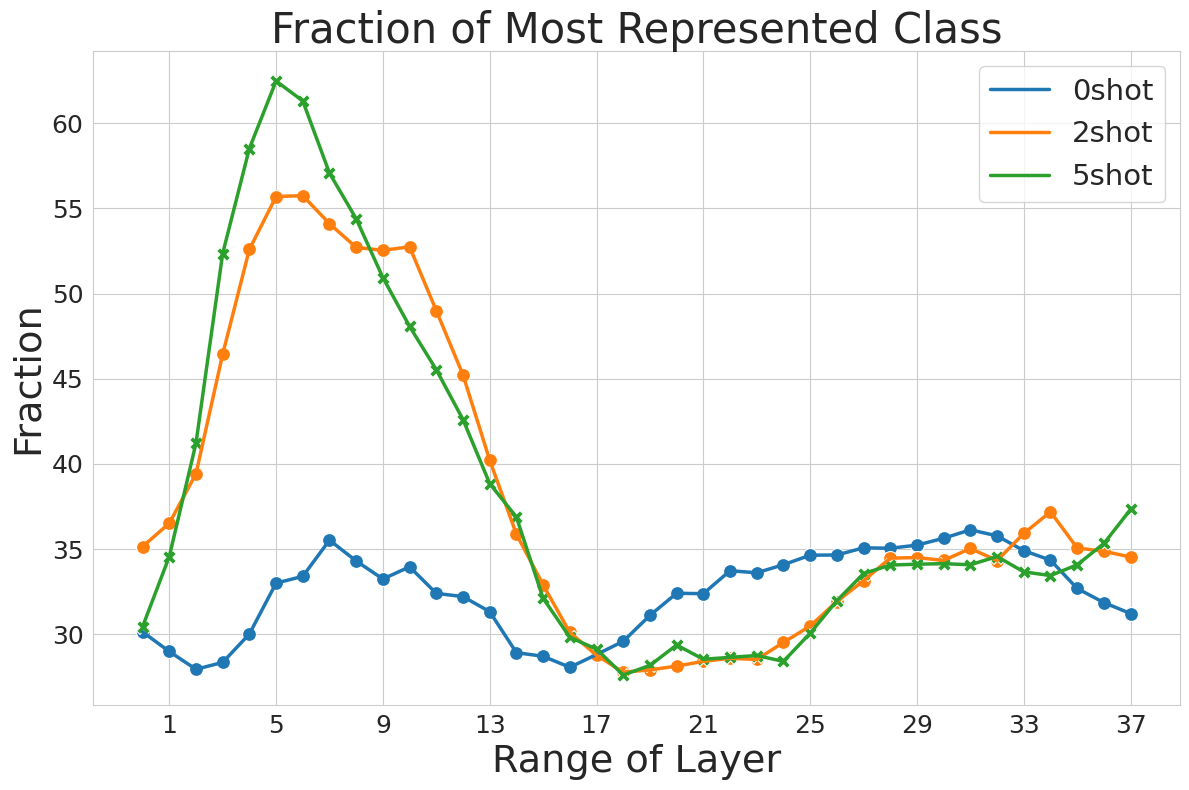

32


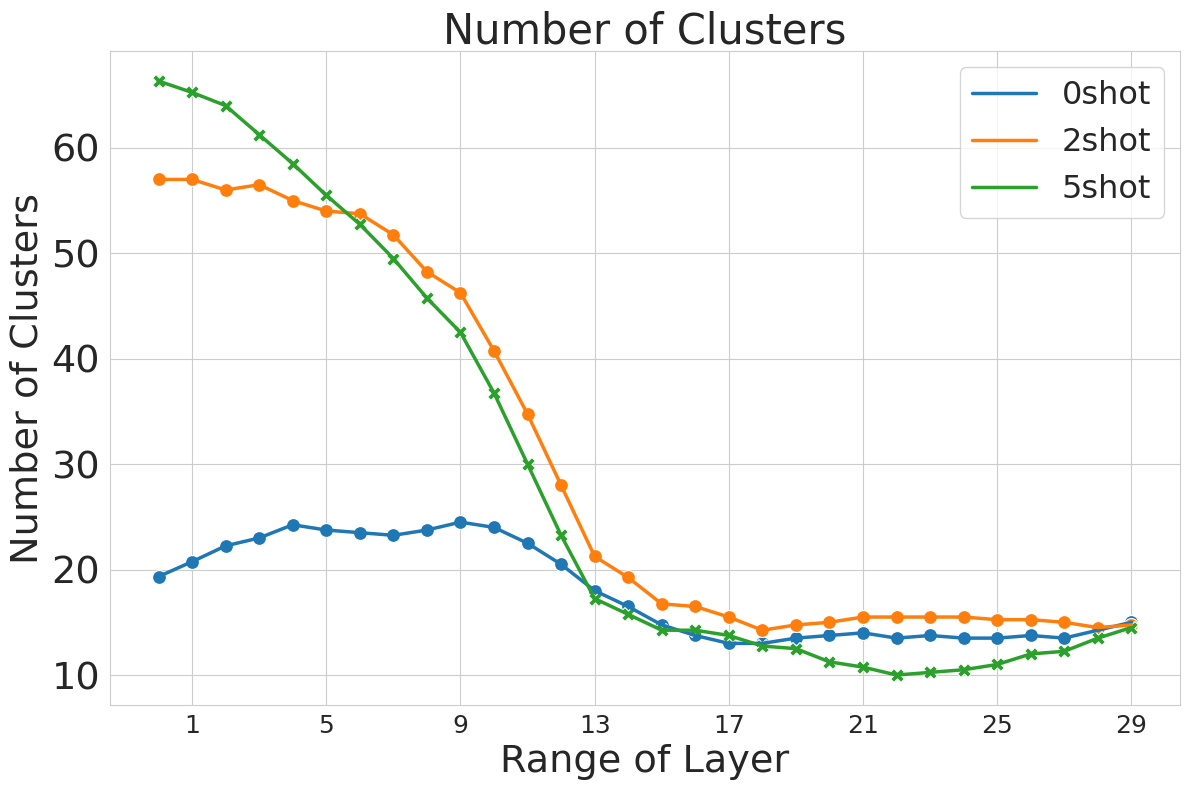

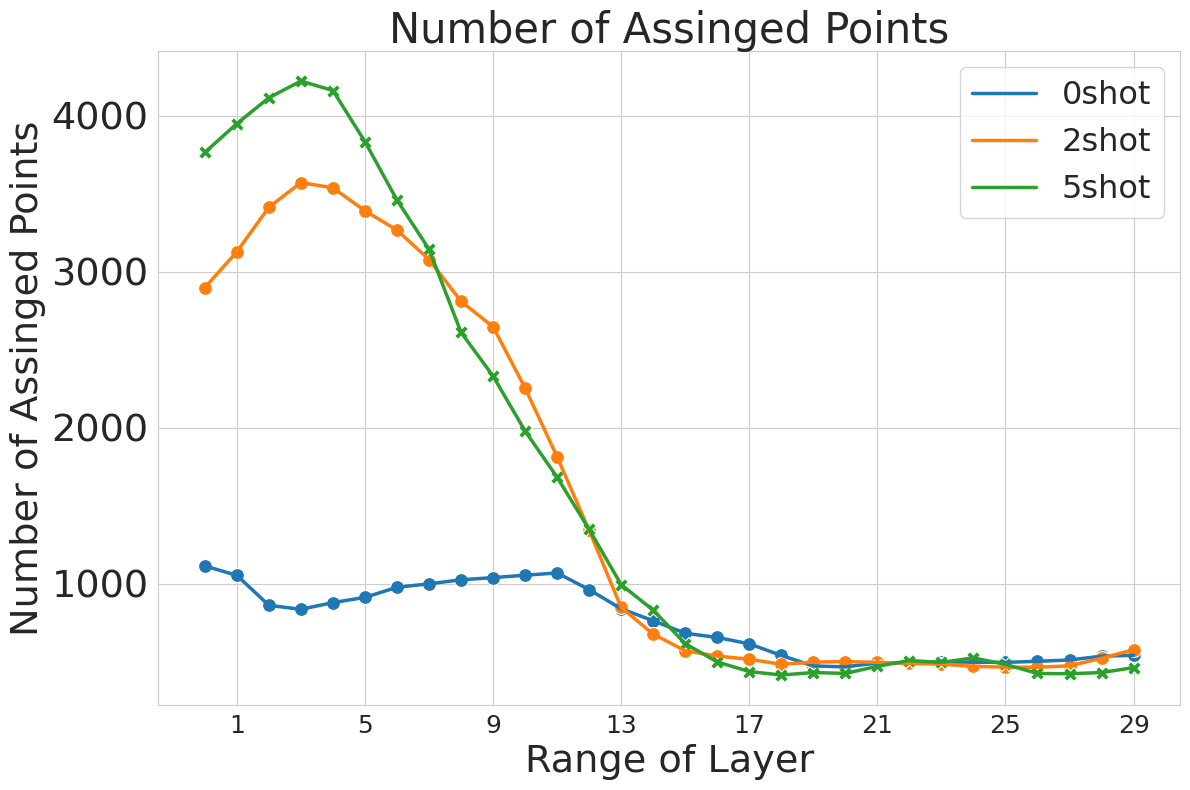

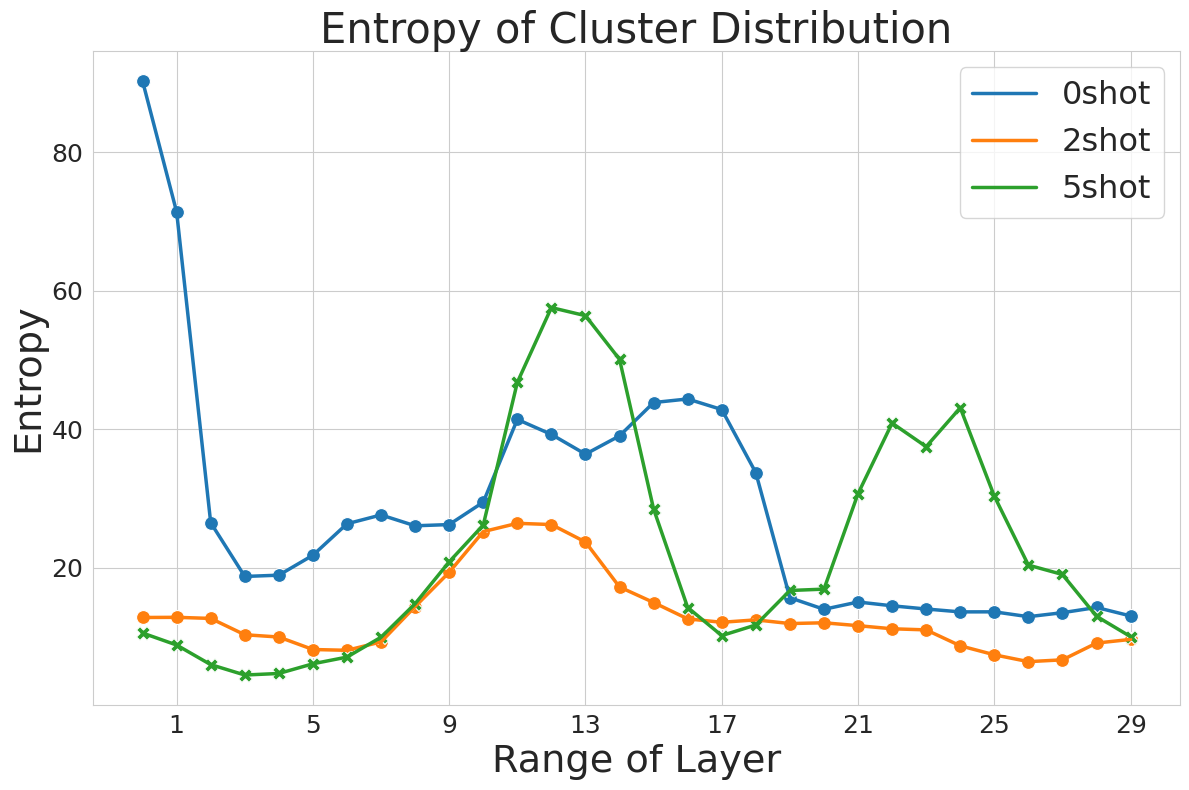

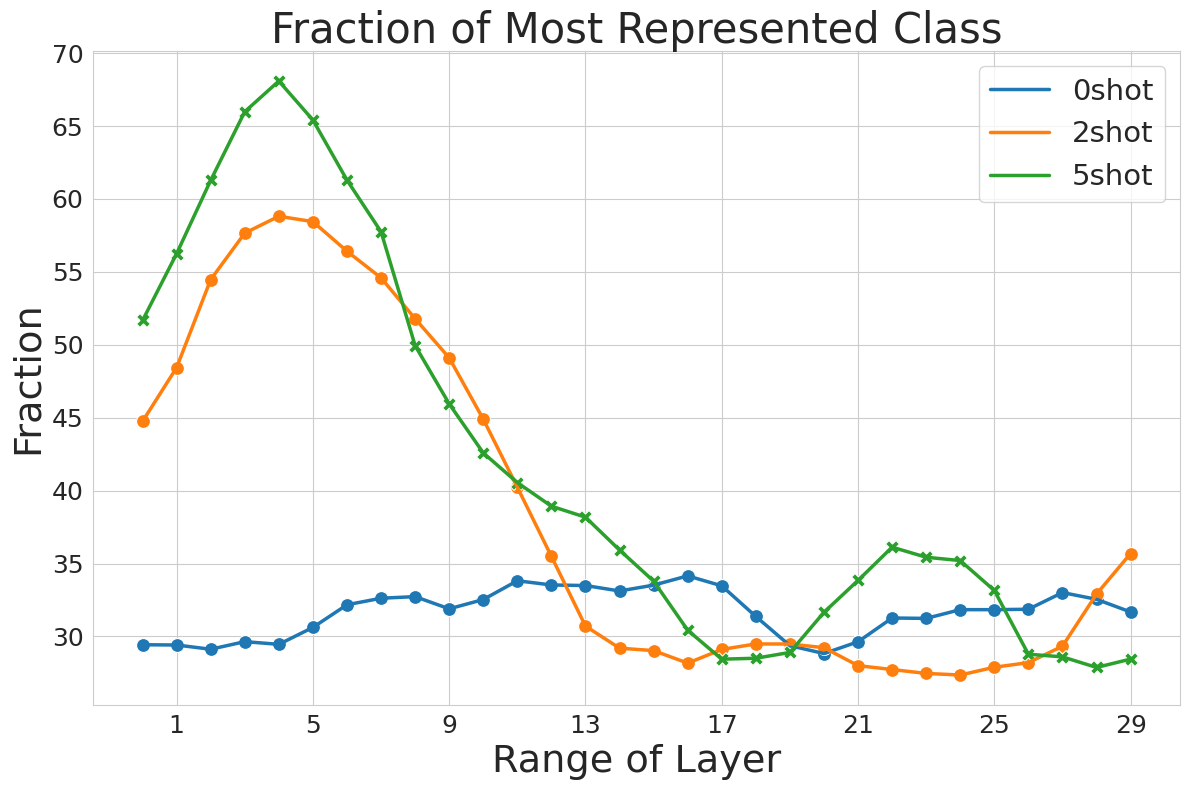

80


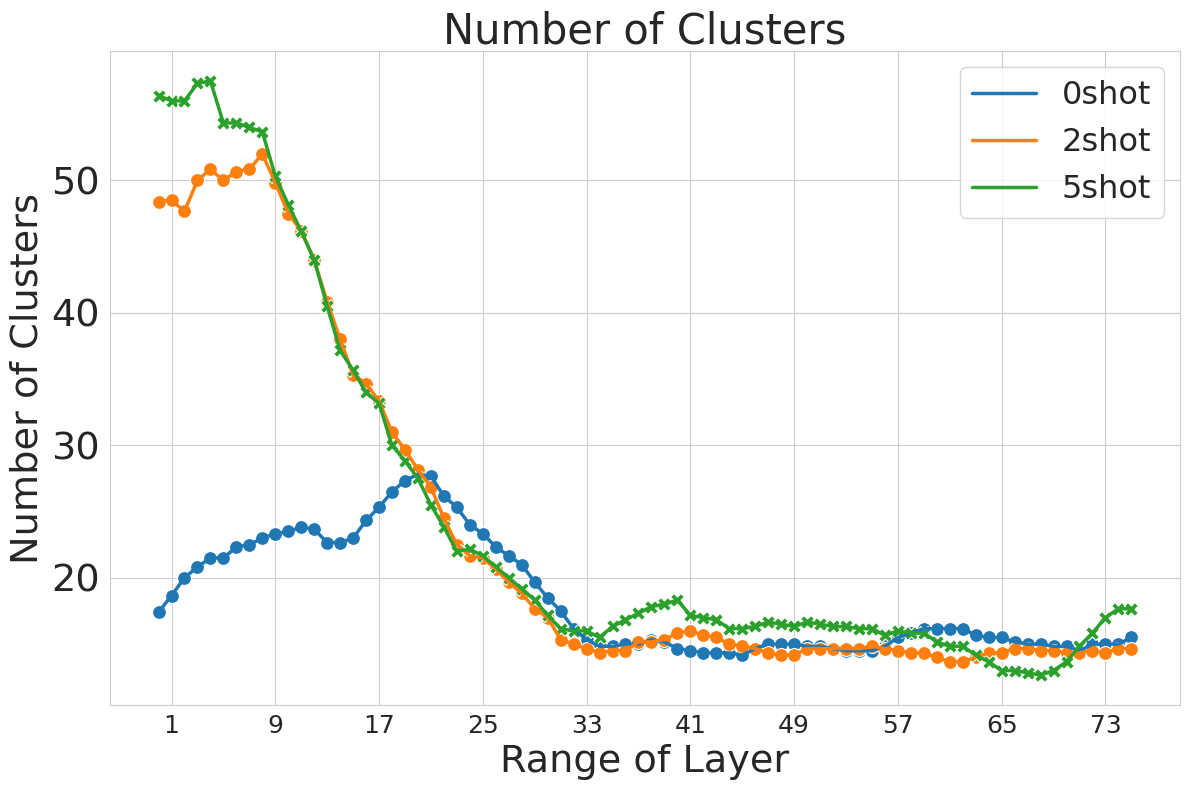

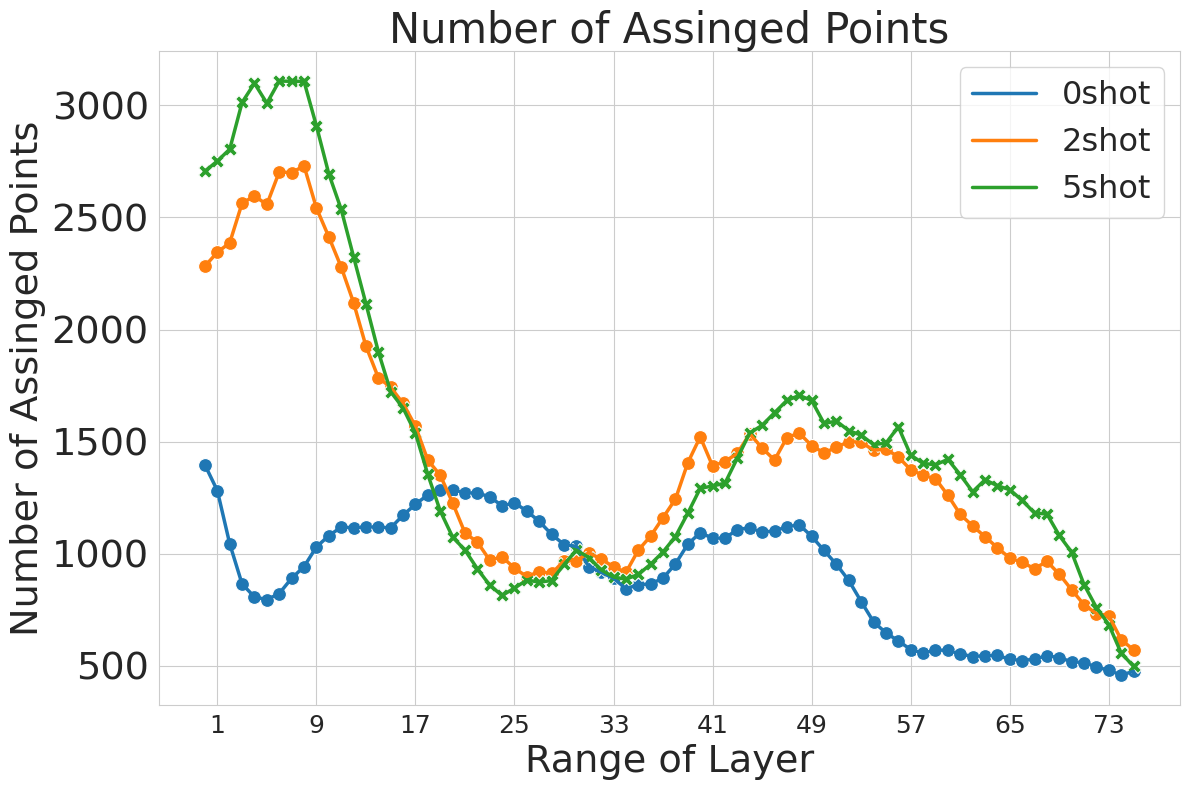

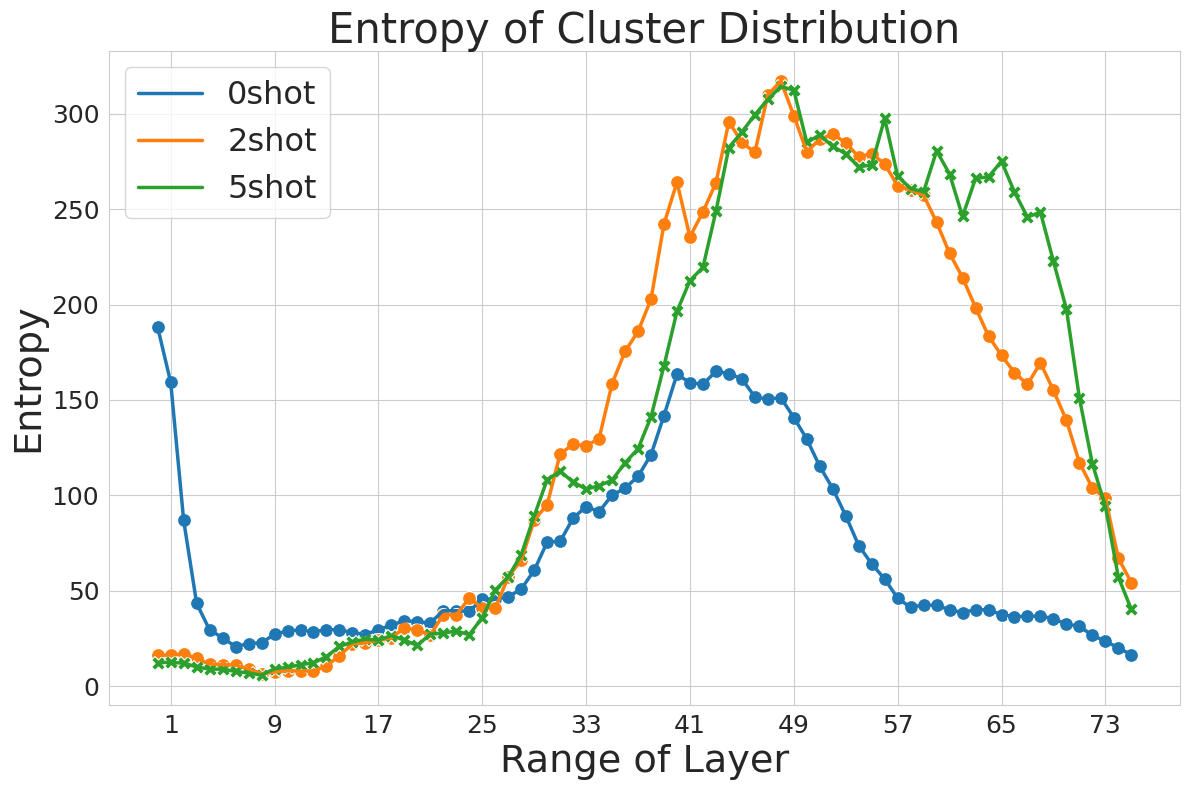

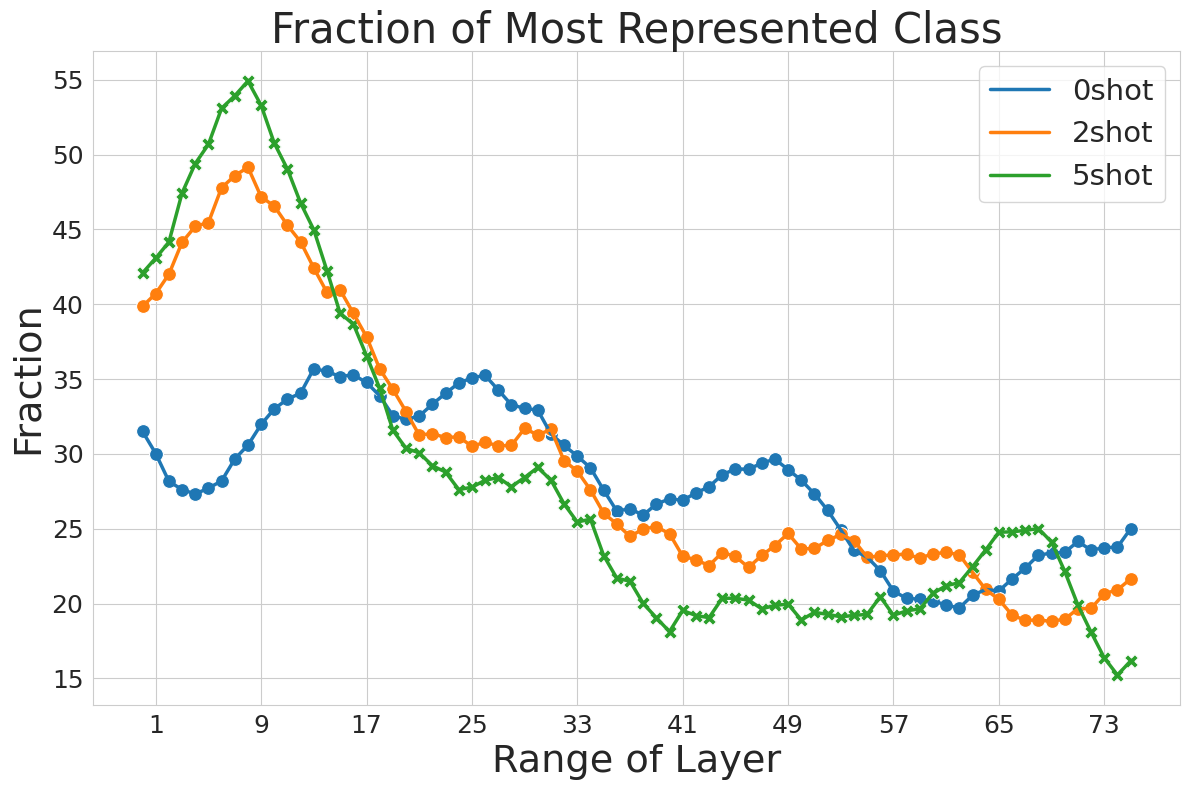

In [58]:
metrics = compute_metrics(df)
models = ["meta-llama-Llama-2-13b-hf",
          "meta-llama-Llama-3-8b-hf",
          "meta-llama-Llama-3-70b-hf"]
for model in models:
    plot_metrics(metrics,model)
    # plot_box(metrics, model)

# Non avg

In [ ]:
def plot_box(metrics, model):
    plt.figure(figsize=(conf_size.width, conf_size.height))
    sns.set_style("whitegrid")
    metrics_0 = metrics.query(f"model=='{model}'" \
                              f"and shot==0")
    metrics_2 = metrics.query(f"model=='{model}'" \
                              f"and shot==2")
    metrics_5 = metrics.query(f"model=='{model}'" \
                              f"and shot=={determine_shot(model)}")


    n_layers = metrics_0["num_clusters"].values[0].shape[0]
    if "70" in model:
        n = 5
    else:
        n = 3
    
    if n_layers < 50:
        tick_positions = np.arange(1, n_layers, 4)  # Generates positions 0, 4, 8, ...
    else:
        tick_positions = np.arange(1, n_layers, 8)  # Generates positions 0, 4, 8, ...
    
    tick_labels = tick_positions  # Get the corresponding labels from x
    print(n_layers)
    for n,ctx in enumerate(zip([metrics_0,metrics_2,metrics_5],
                            ["0shot", "2shot", "5shot"]
                           )):
        plt.figure(figsize=(conf_size.width, conf_size.height))
        sns.set_style("whitegrid")
        metrics_iter,label = ctx
        # CLUSTER SIZE DISTRIBUTION
        colors = plt.cm.viridis(np.linspace(0, 1, n_layers))
        csd_data = []
        for i in range(n_layers):
            for _ in range(int(np.random.rand() * 10 + 10)):  # Random replication for illustrative purposes
                csd_data.append({
                    "Layer": f"Layer {i+1}",
                    "Cluster Size": np.random.normal(metrics_iter["mean_cluster_size"].values[0][i], np.sqrt(metrics_iter["var_cluster_size"].values[0][i]))
                })

        df = pd.DataFrame(csd_data)
        y=metrics_iter["fraction_most_represented"].values[0]
        layers = np.array(range(n_layers))
        x_avg, y_avg = average_custom_blocks(layers, df["Cluster Size"].values, n)
        df = pd.DataFrame({"Range of Layer": x_avg, "Cluster Size": y_avg})
        sns.boxplot(x='Range of Layer', y='Cluster Size', data=df, hue='Range of Layer', legend=False,palette="viridis")
        avg_metrics_iter_mean, avg_metrics_iter_var = average_custom_blocks(metrics_iter["mean_cluster_size"].values[0], metrics_iter["var_cluster_size"].values[0], n)
        avg_metrics_iter_var = np.sqrt(avg_metrics_iter_var)
        colors = plt.cm.viridis(np.linspace(0, 1, avg_metrics_iter_mean.shape[0]))
        for i,(mean,var) in enumerate(zip(avg_metrics_iter_mean, avg_metrics_iter_var)):
            plt.errorbar(i, mean, yerr=var, fmt='o-', color=colors[i])
        plt.title(f"Cluster Size Distribution {label}", fontsize=conf_size.title)
        plt.xlabel("Range of Layer", fontsize=conf_size.xlabel)
        plt.ylabel("Mean +/- SD", fontsize=conf_size.ylabel)
        plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=conf_size.xticks)
        plt.tick_params(axis='y', labelsize=conf_size.yticks)
        plt.legend(fontsize=conf_size.legend)
        plt.savefig(f"plots_clustering/{model[11:][:-3]}-{label}-box.png")
        plt.tight_layout()
        plt.show()

